## **SENTIMENT ANALYSIS** 

### **Session Prep**

In [ ]:
#packages needed

#ignore warnings about future changes in functions as they take too much space
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

#the module 'sys' allows istalling module from inside Jupyter
import sys

!{sys.executable} -m pip install numpy
import numpy as np 

!{sys.executable} -m pip install pandas
import pandas as pd

#Natrual Language ToolKit (NLTK)
!{sys.executable} -m pip install nltk
import nltk

#text normalization function
%run ./Text_Normalization_Function.ipynb

#ignore warnings about future changes in functions as they take too much space
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn import metrics


### **Dataset**



In [7]:
import pickle 

path = ''

test_data = pd.read_pickle(path + 'mreviews_test.pkl')
train_data = pd.read_pickle(path + 'mreviews_train.pkl')

print("Dimensions for test data:", test_data.shape)
print("Dimensions for training data:", train_data.shape,"\n")
print("First 5 rows in test dataset: \n", test_data.head(),"\n")
print("First 5 rows in  training dataset: \n", train_data.head())

Dimensions for test data: (1000, 3)
Dimensions for training data: (1000, 3) 

First 5 rows in test dataset: 
     file_name                                        review_text  polarity
0    0_10.txt  I went and saw this movie last night after bei...  positive
0  100_10.txt  The finest short I've ever seen. Some commenta...  positive
0   101_9.txt  This is a very, very odd film...one that is so...  positive
0   102_8.txt  Although Bullet In The Brain is, without quest...  positive
0  103_10.txt  ...means "take up and read", which is precisel...  positive 

First 5 rows in  training dataset: 
     file_name                                        review_text  polarity
0     0_9.txt  Bromwell High is a cartoon comedy. It ran at t...  positive
0   100_7.txt  Scott Bartlett's 'OffOn' is nine minutes of pu...  positive
0   101_8.txt  IMDb lists this as 1972 for some reason, but t...  positive
0  102_10.txt  I first heard about this film about 20 years a...  positive
0   103_7.txt  when i read

Each dataframe consists of **3 columns**: 

- **file_name** (the name of the file with review text), 
- **review_text** (the text of the review), 
- **polarity** (label for binary sentiment polarity created by a human: positive or negative). 

In [8]:
test_reviews = np.array(test_data['review_text'])
test_polarity = np.array(test_data['polarity'])

train_reviews = np.array(train_data['review_text'])
train_polarity = np.array(train_data['polarity'])

## **Lexicon-Based Sentiment Analysis (Unsupervised Machine Learning)**

### **VADER Lexicon**

In [62]:
def vader_lexicon_best_threshold(test_reviews):
     
     nltk.download('vader_lexicon')
     analyzer = SentimentIntensityAnalyzer()  #Import the sentiment analysis function SentimentIntensityAnalyzer() that uses the VADER lexicon from the NLTK package.
     polarity_scores = [analyzer.polarity_scores(review) for review in test_reviews] #feed document instead of corpus
     scores = [doc['compound'] for doc in polarity_scores]

     def try_threshold_for_accuracy(sentiment_scores, threshold):
         VADER_polarity = ['positive' if s >= threshold else 'negative' for s in list(sentiment_scores)]
         accuracy = metrics.accuracy_score(test_polarity, VADER_polarity)
         return(accuracy) 

     thresholds = np.linspace(-1,1,1000)
     acc_rates = [try_threshold_for_accuracy(scores,threshold) for threshold in thresholds]

     import matplotlib.pyplot as plt
     plt.plot(thresholds, acc_rates)
     plt.xlabel("Threshold score for positive (binary) sentiment polarity")
     plt.ylabel("Accuracy rate")
     plt.title("Accuracy Rate of Sentiment Polarity Prediction \n as a Function of Threshold for VADER Scores \n")
     plt.show()

     print('Best performance of VADER method: ',round(thresholds[acc_rates.index(max(acc_rates))],4),'\n','\n')
     
     print('Confusion matrix:','\n')
     vader_polarity = pd.Series(scores).apply(lambda x: 'positive' if x >= 0.8218 else 'negative')
     cm = pd.crosstab(pd.Series(test_polarity), 
                    pd.Series(VADER_polarity_test_df['VADER Polarity']), 
                    rownames = ['True:'], 
                    colnames = ['Predicted:'], 
                    margins = True)
     print(cm)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/kkee/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


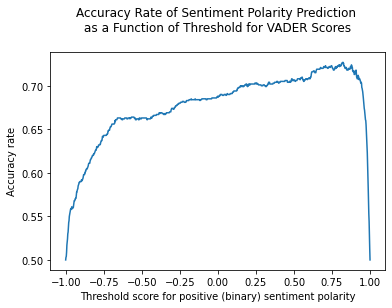

Best performance of VADER method:  0.8218 
 

Confusion matrix: 

Predicted:  negative  positive   All
True:                               
negative         265       235   500
positive          72       428   500
All              337       663  1000


In [63]:
vader_lexicon_best_threshold(test_reviews)

### **Training your Own Sentiment Classifier (Supervised Machine Learning)**

### normalization & vectorization

In [23]:
normalized_test_reviews = normalize_corpus(test_reviews)
normalized_train_reviews = normalize_corpus(train_reviews)

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range = (1,2)) 
feature_matrix_TRAIN = vectorizer.fit_transform(normalized_train_reviews).astype(float)
feature_matrix_TEST = vectorizer.transform(normalized_test_reviews)

### training & scoring

#### SVM

In [59]:
from sklearn import linear_model

svm = linear_model.SGDClassifier(loss='hinge', random_state = 0) 
svm.fit(feature_matrix_TRAIN, train_polarity)
predicted_svm = svm.predict(feature_matrix_TEST) 
print('Test accuracy of SVM:', np.round(metrics.accuracy_score(test_polarity, predicted_svm), 3))

Test accuracy of SVM: 0.798


#### Logistic regression

In [60]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(multi_class='ovr',solver='sag',class_weight='balanced')
lr.fit(feature_matrix_TRAIN,train_polarity)
test_score=lr.score(feature_matrix_TEST,test_polarity)
print('Test accuracy of logistic regression：',test_score)

Test accuracy of logistic regression： 0.808


##### Sample

In [61]:
sample_ids = [0, 30, 330, 855, 951, 995] 
for doc_index in sample_ids:
    print('Review:-')
    print(test_reviews[doc_index])
    print('\nActual Labeled Sentiment:', test_polarity[doc_index])
    print('Predicted Sentiment:', predicted_svm[doc_index])   
    print('-'*60)

Review:-
I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.

Actual Labeled Sentiment: positive
Predicted Sentiment: positive
------------------------------------------------------------
Review:-
If you have not seen this late 80s film about the the Washin